In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

data = []
with open('endomondoHR_proper.json') as f:
    for line in f:
        data.append(eval(line))  
np.random.seed(42) 
np.random.shuffle(data)

# Split the data into 40% and 60%
split_index = int(len(data) * 0.4)
data_40 = data[:split_index]
data_60 = data[split_index:]


with open('endomondoHR_40.json', 'w') as f:
    json.dump(data_40, f)

# Alternatively, save as a .npy file
np.save('endomondoHR_40.npy', data_40)



In [3]:
data = np.load('endomondoHR_40.npy', allow_pickle=True)

In [4]:
len(data)

67113

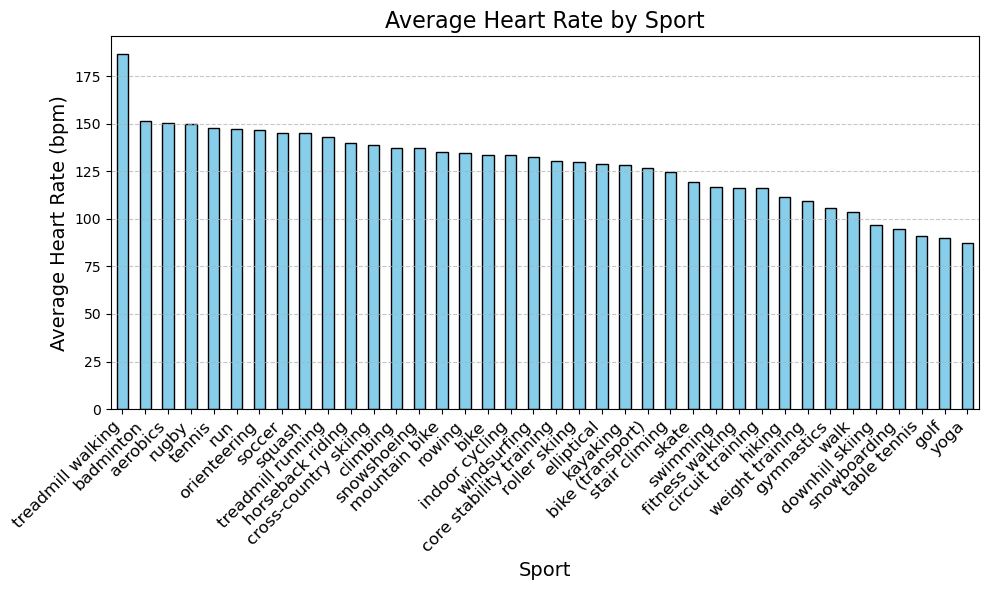

In [5]:
# Step 1: Process data into a DataFrame
records = []

for entry in data:
    try:
        # Ensure required fields exist
        sport = entry.get('sport', None)
        heart_rate_list = entry.get('heart_rate', [])
        timestamp_list = entry.get('timestamp', [])
        
        # Check if lengths of heart_rate and timestamp lists are equal
        if len(heart_rate_list) == len(timestamp_list):
            avg_heart_rate = sum(heart_rate_list) / len(heart_rate_list)
            records.append({
                'sport': sport,
                'avg_heart_rate': avg_heart_rate
            })
    except Exception as e:
        print(f"Error processing entry: {e}")

df = pd.DataFrame(records)

# Step 2: Calculate sport-level average heart rate
sport_avg_heart_rate = (
    df.groupby('sport')['avg_heart_rate']
    .mean()
    .sort_values(ascending=False)
)

# Step 3: Plot the bar graph
plt.figure(figsize=(10, 6))
sport_avg_heart_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Heart Rate by Sport', fontsize=16)
plt.xlabel('Sport', fontsize=14)
plt.ylabel('Average Heart Rate (bpm)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


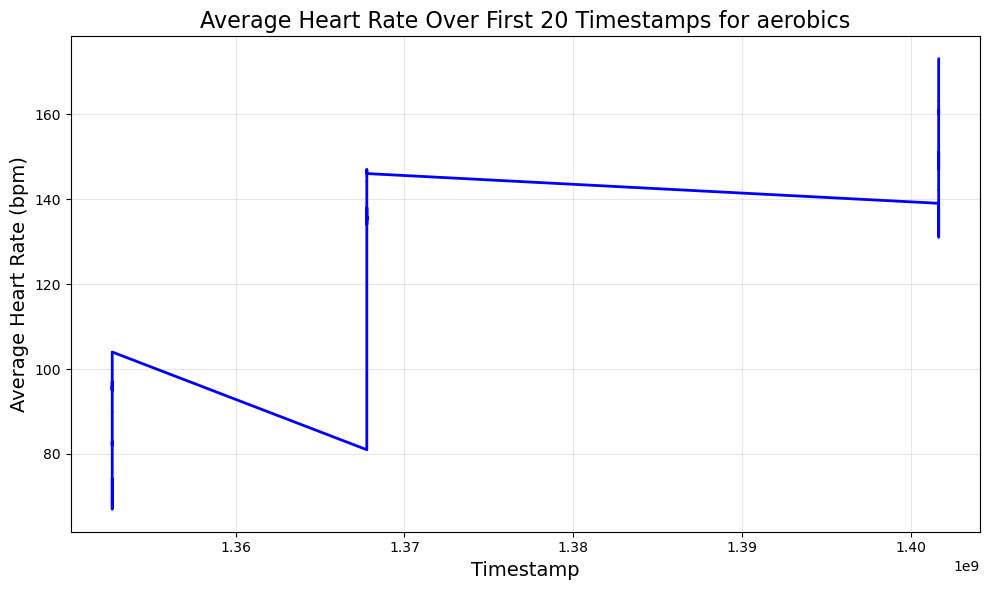

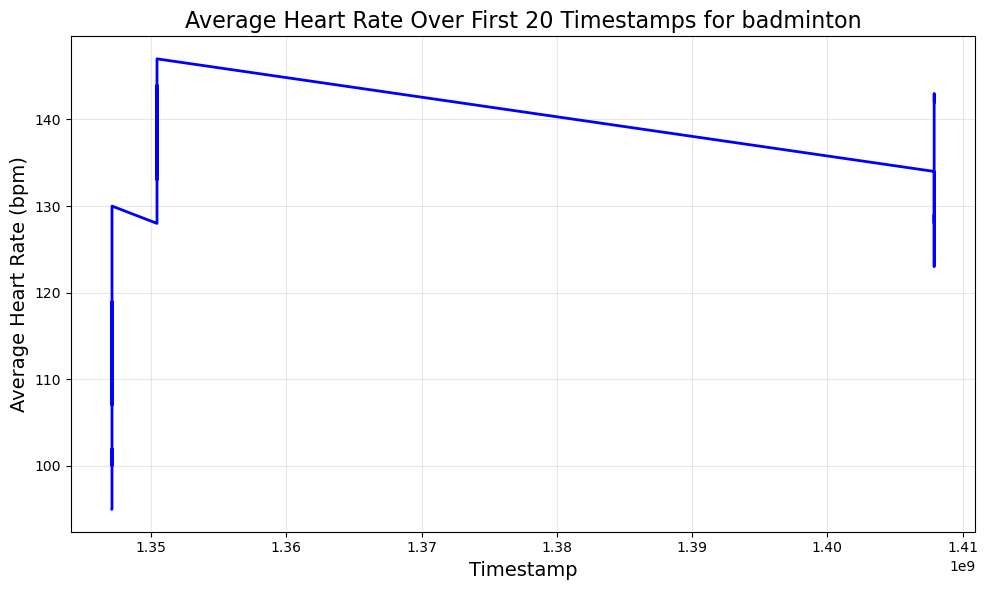

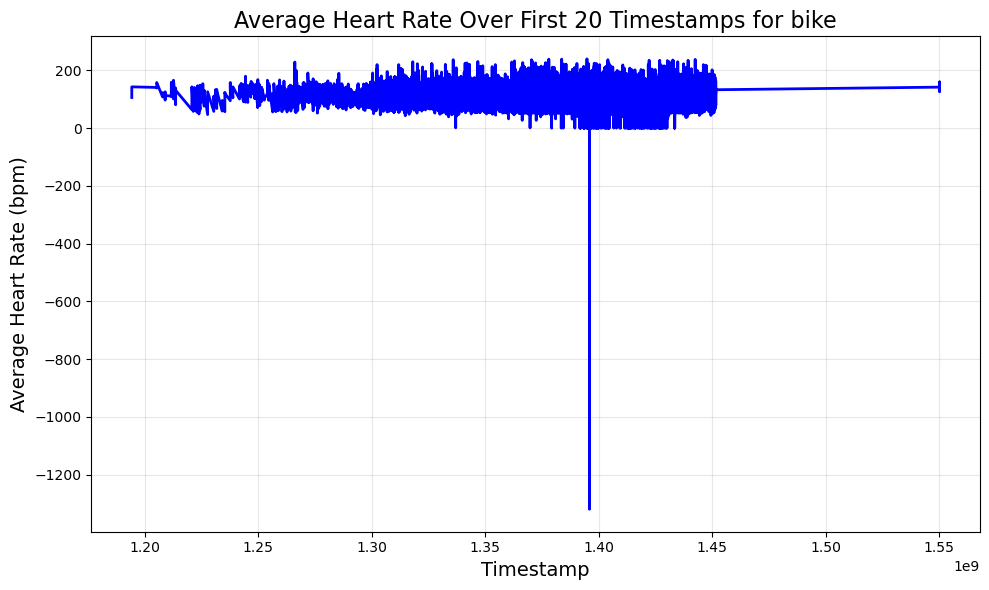

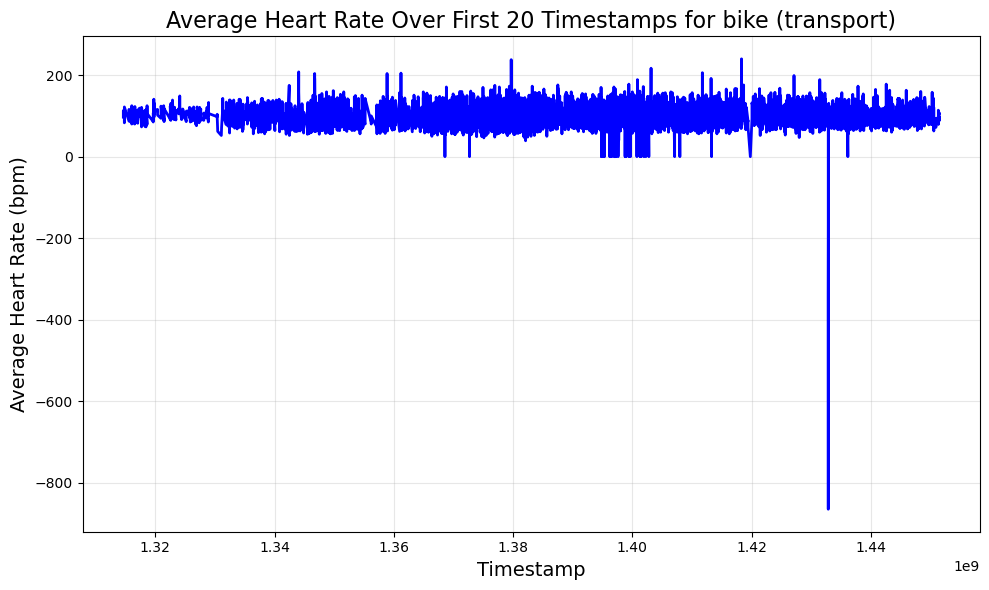

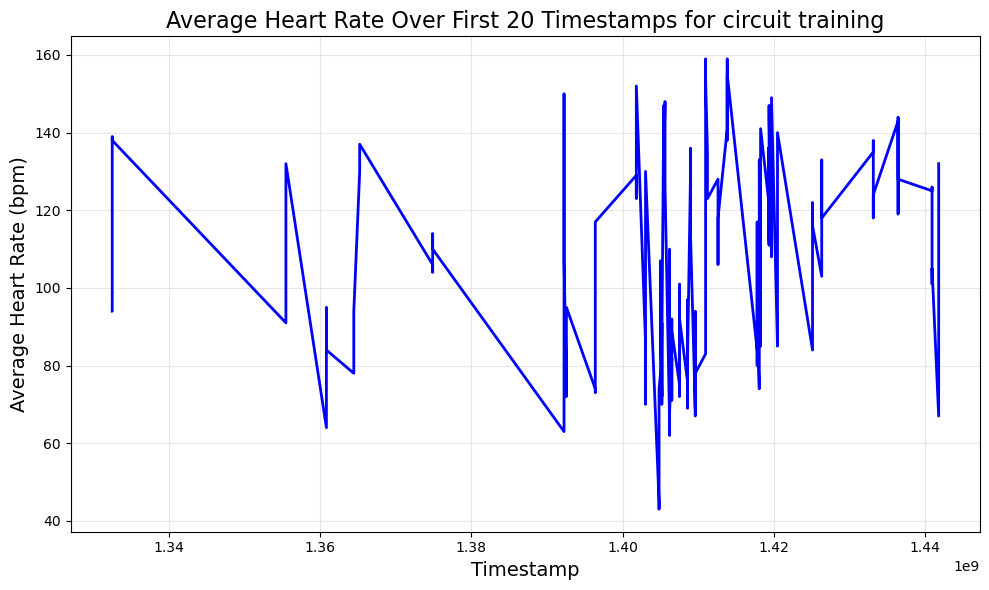

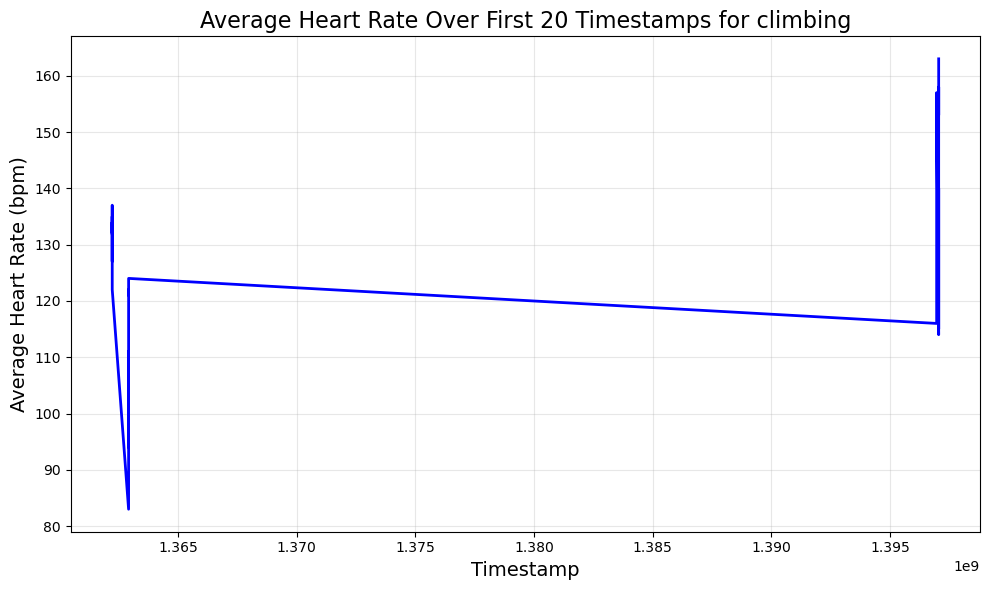

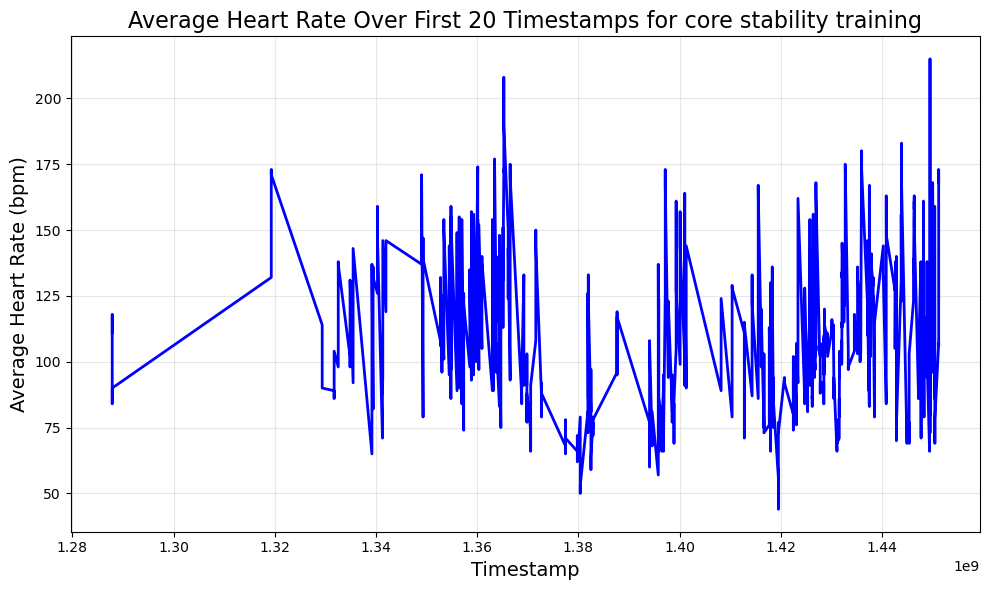

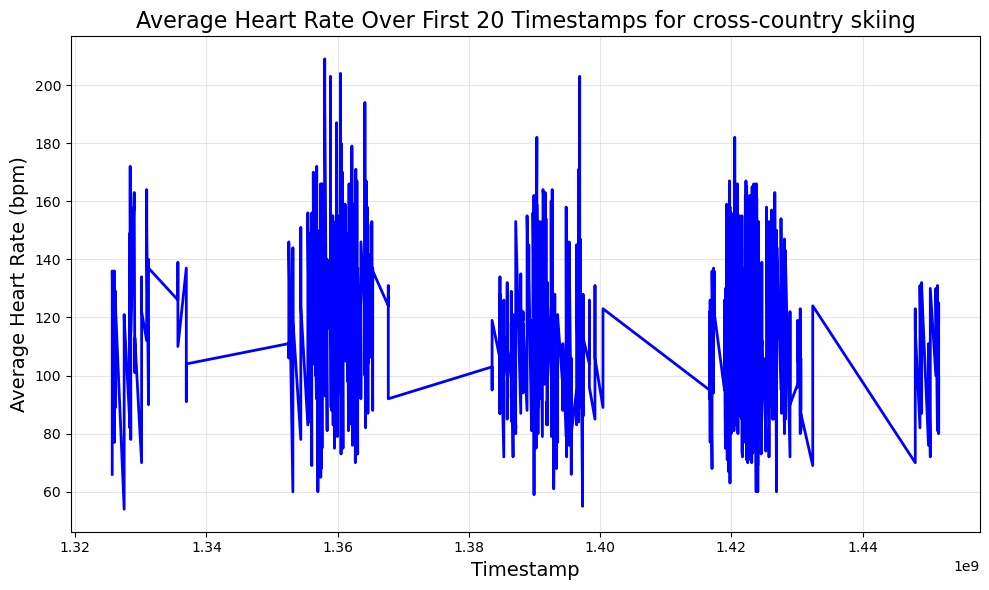

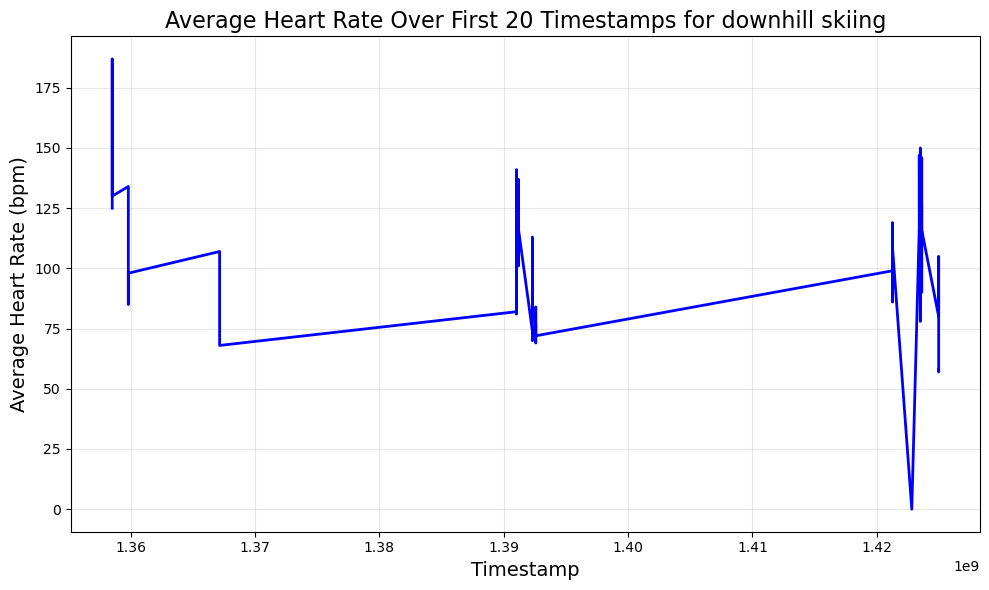

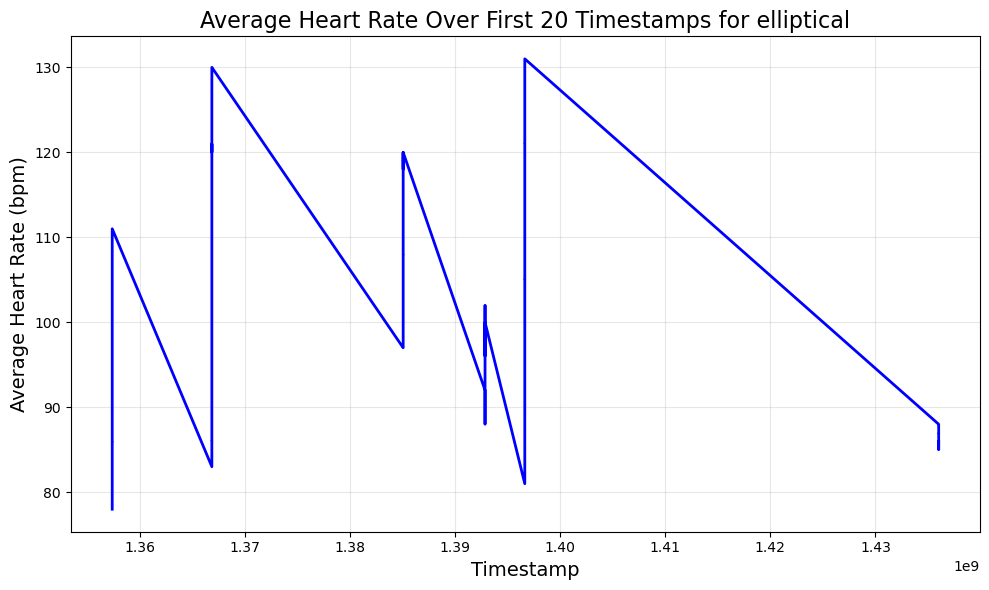

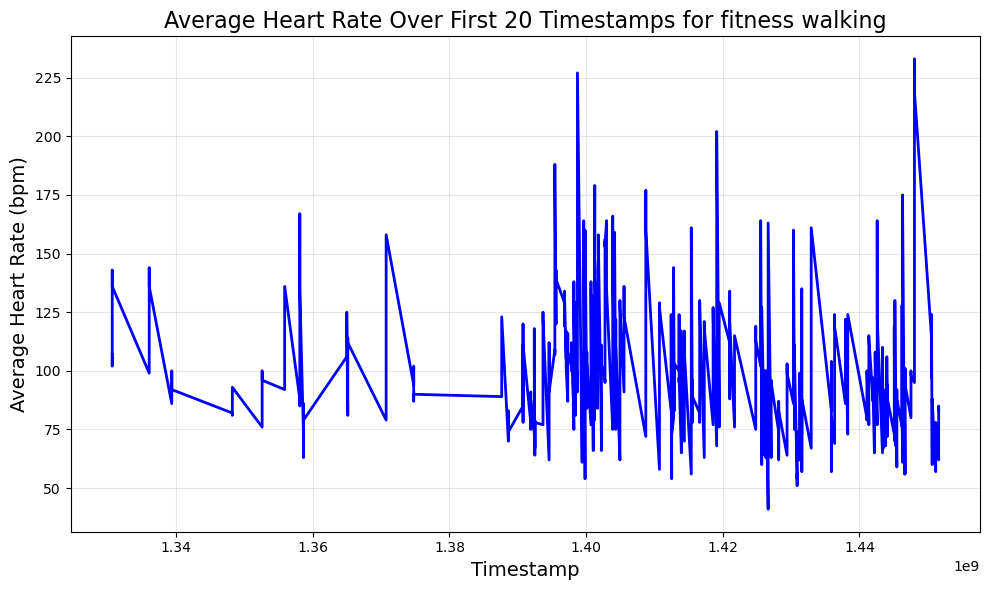

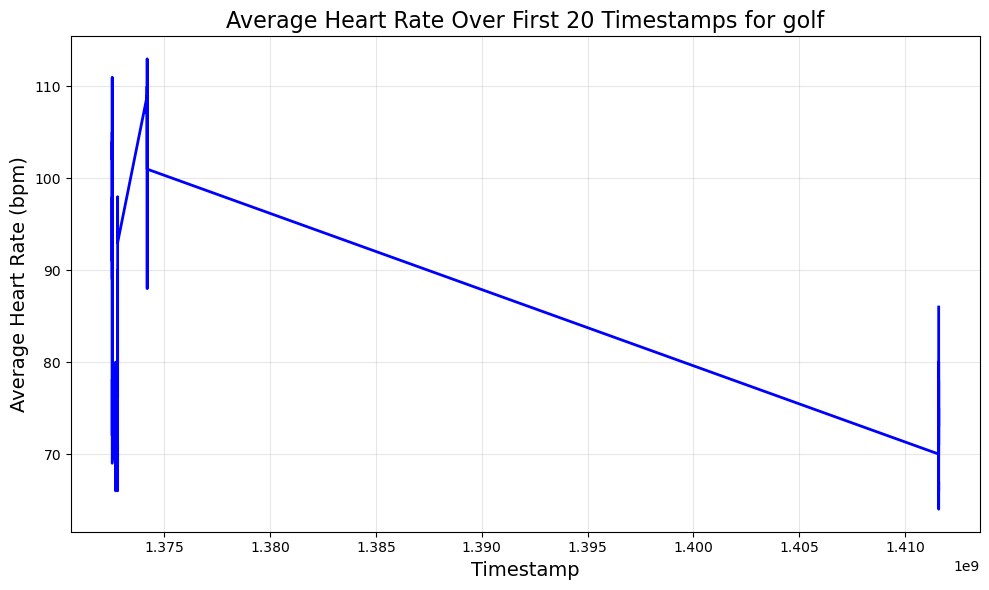

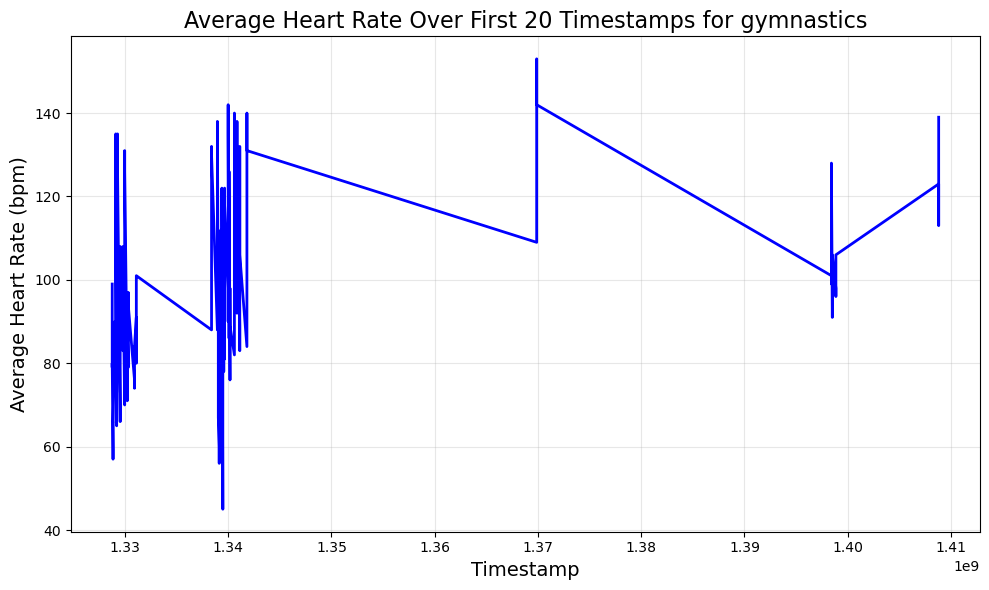

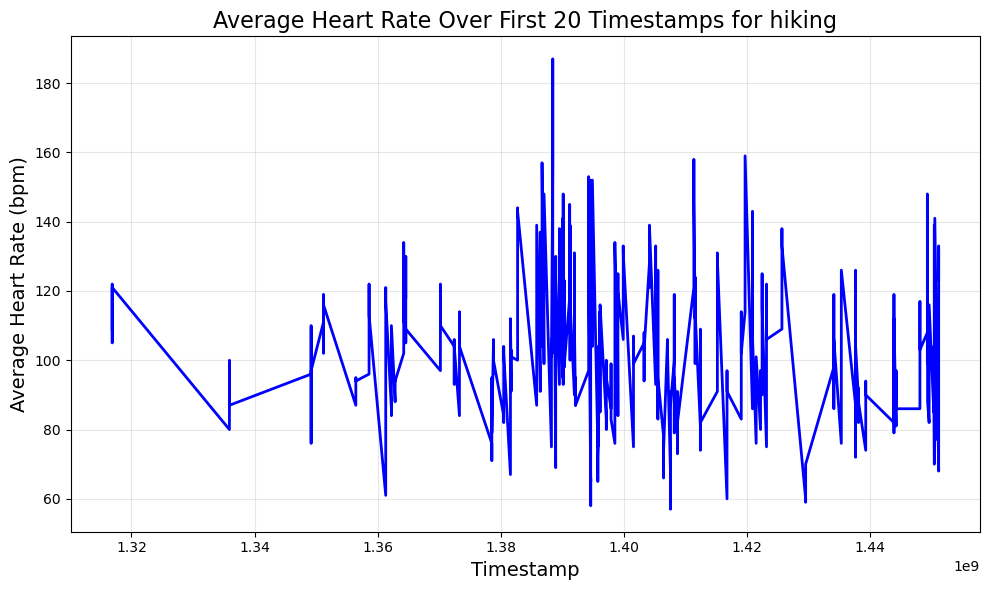

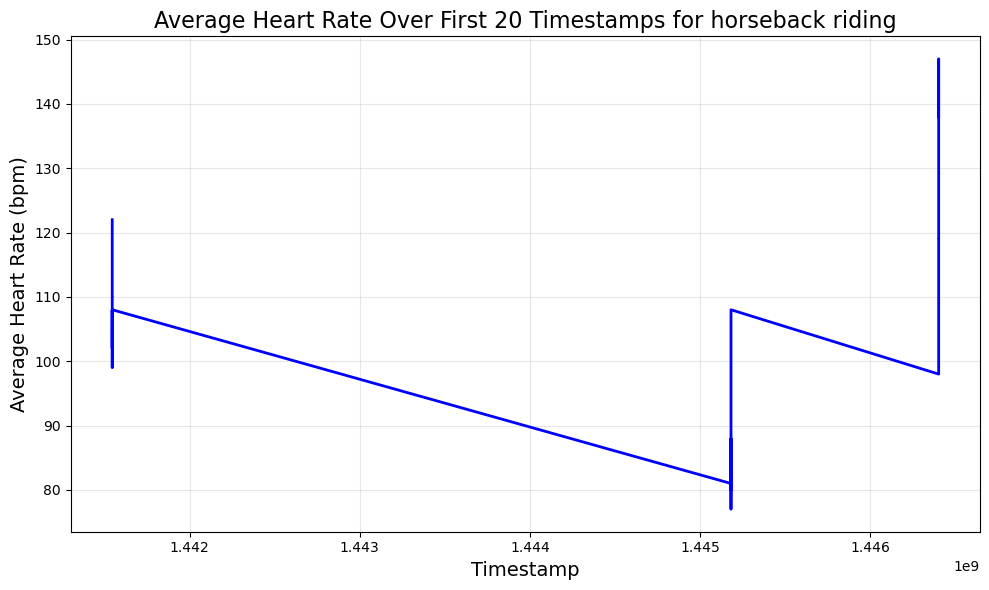

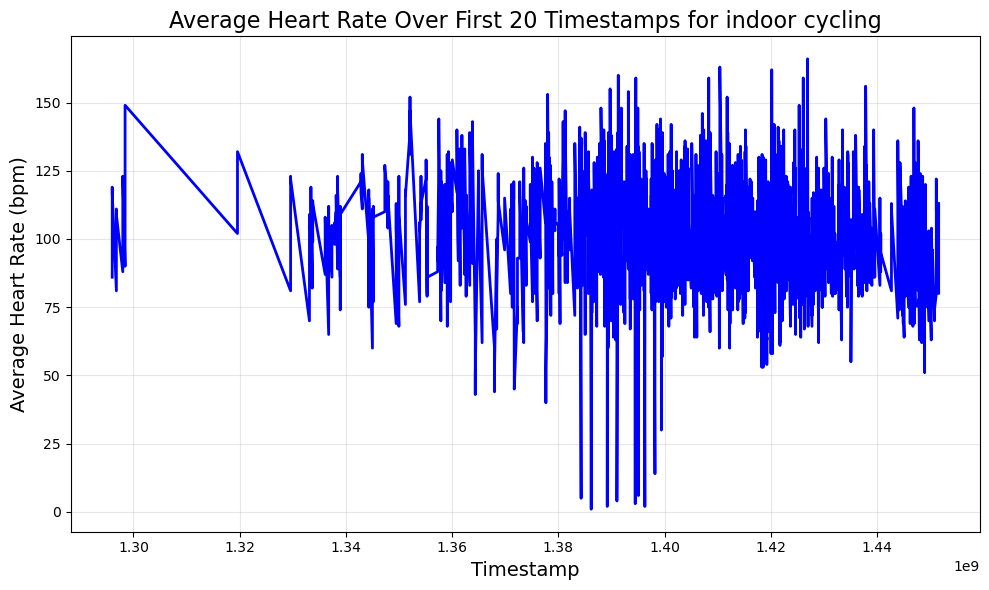

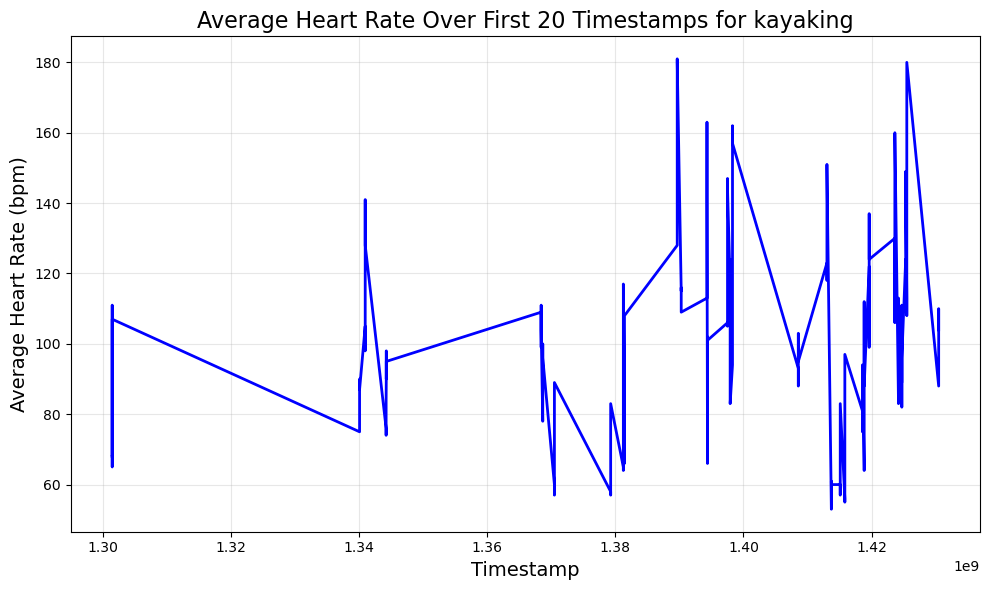

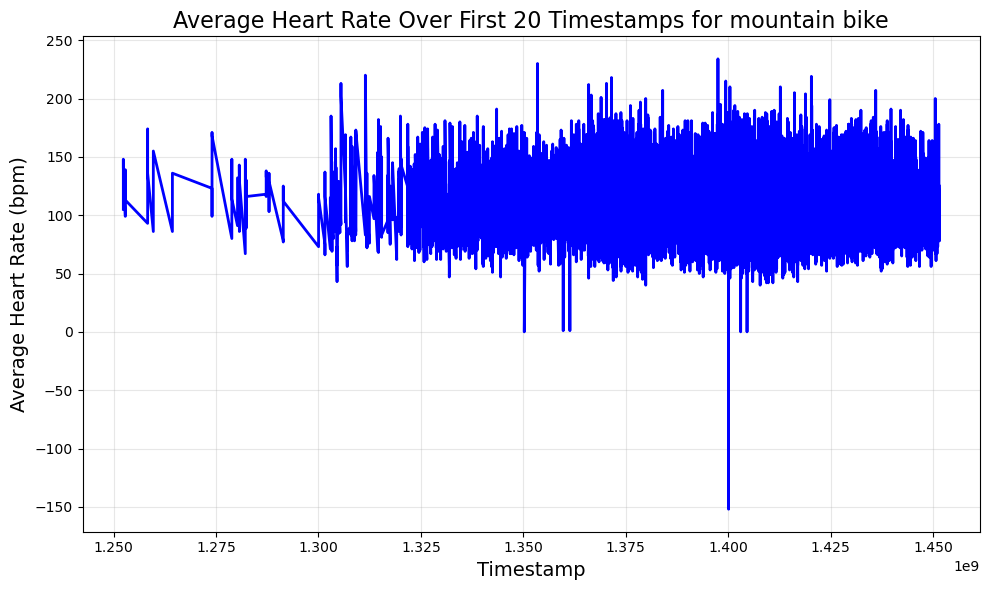

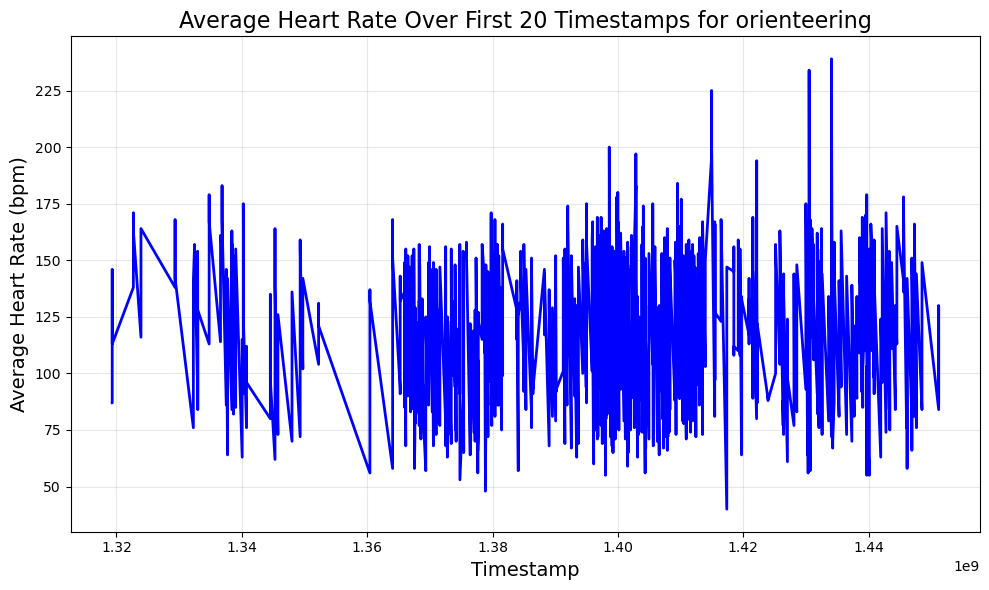

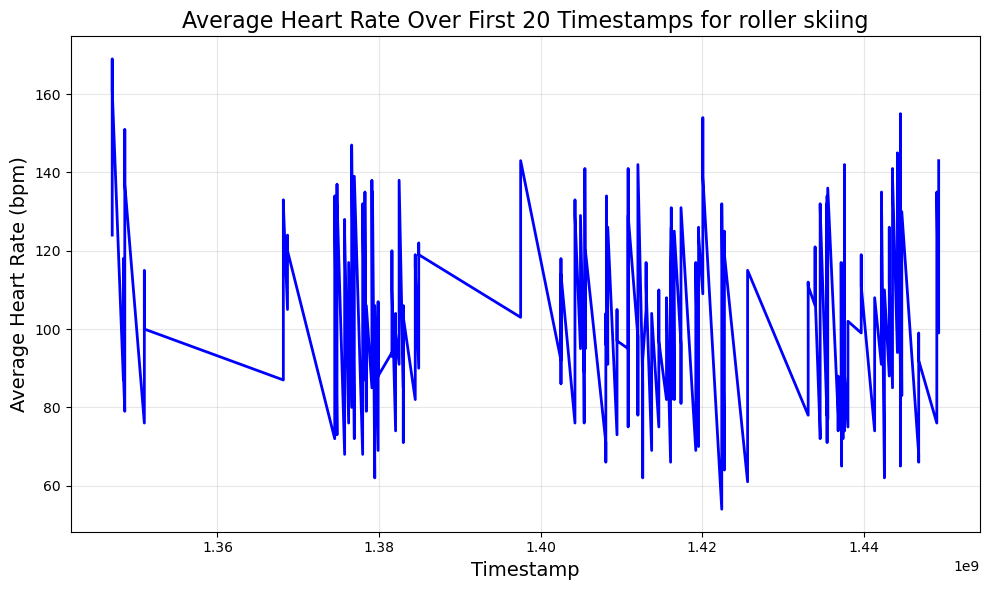

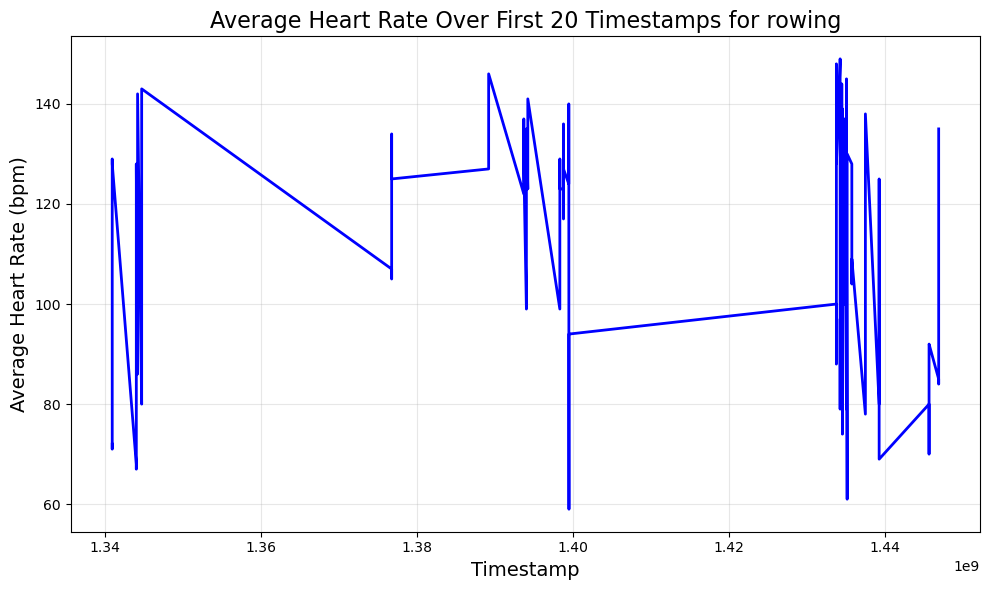

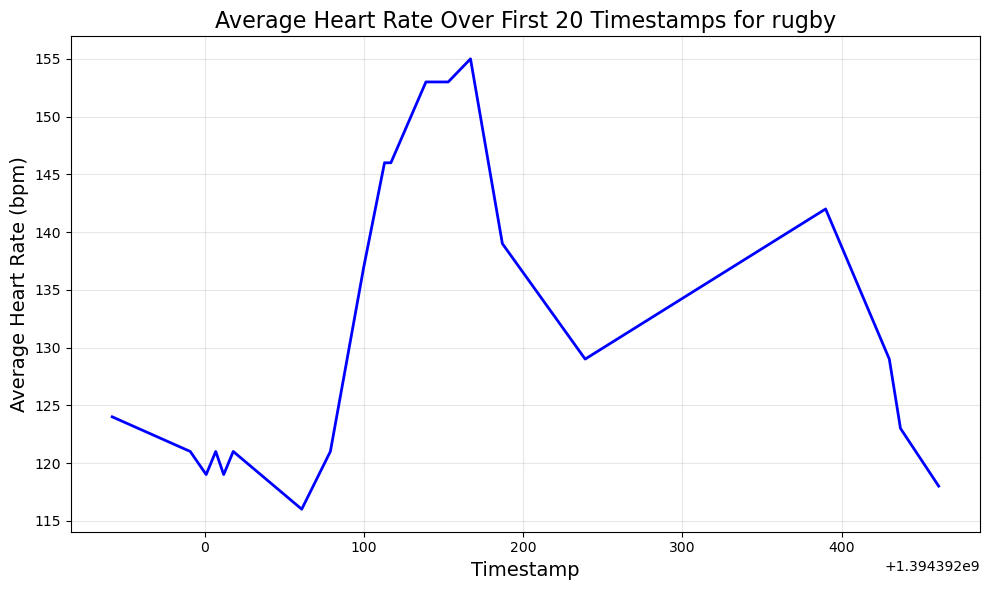

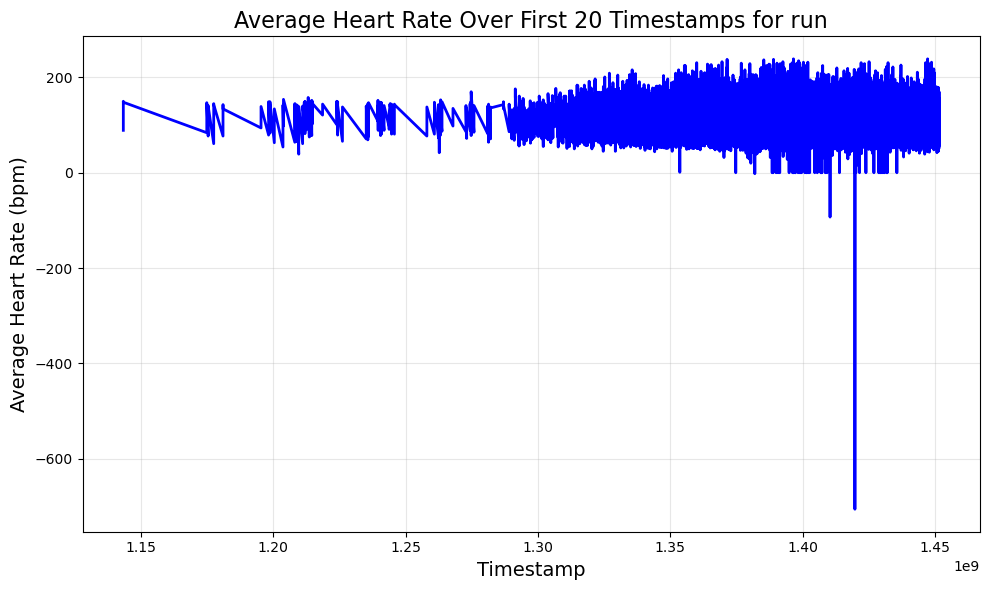

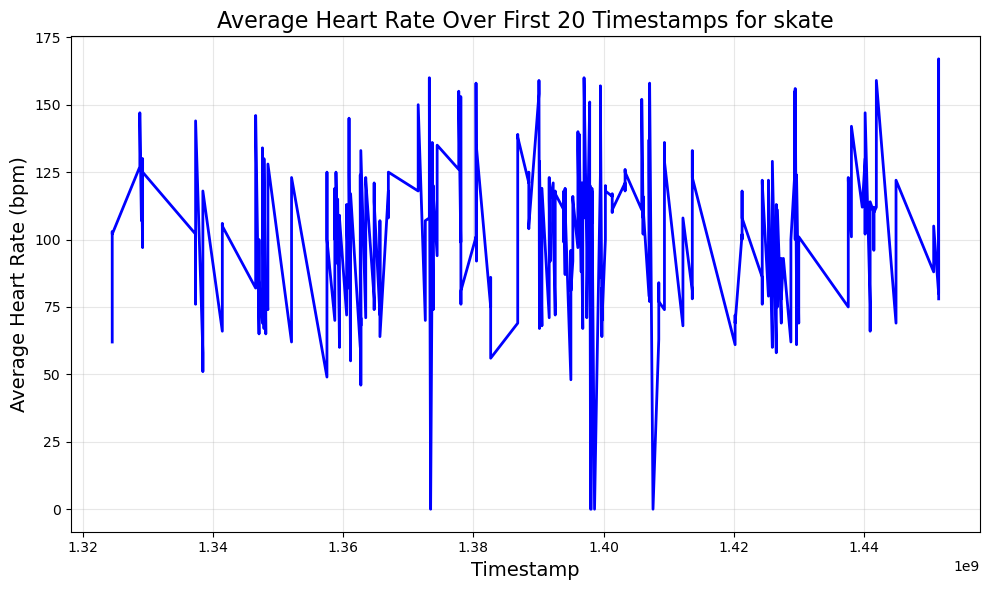

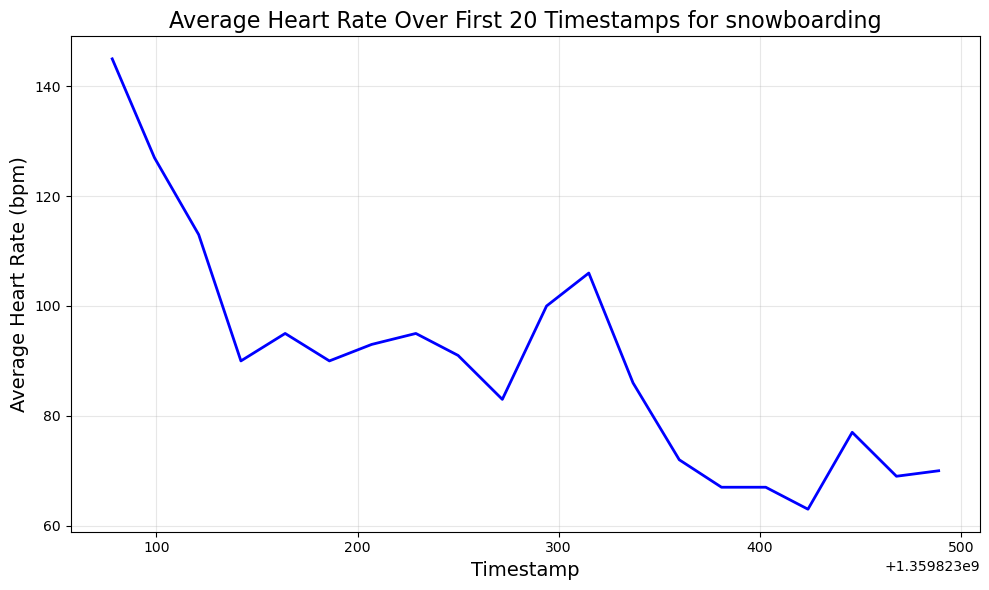

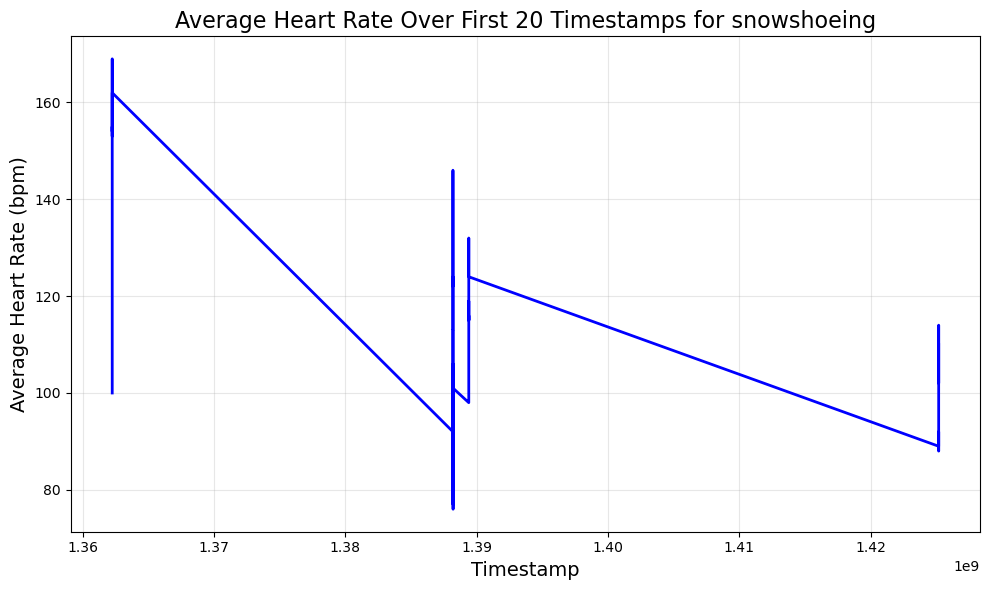

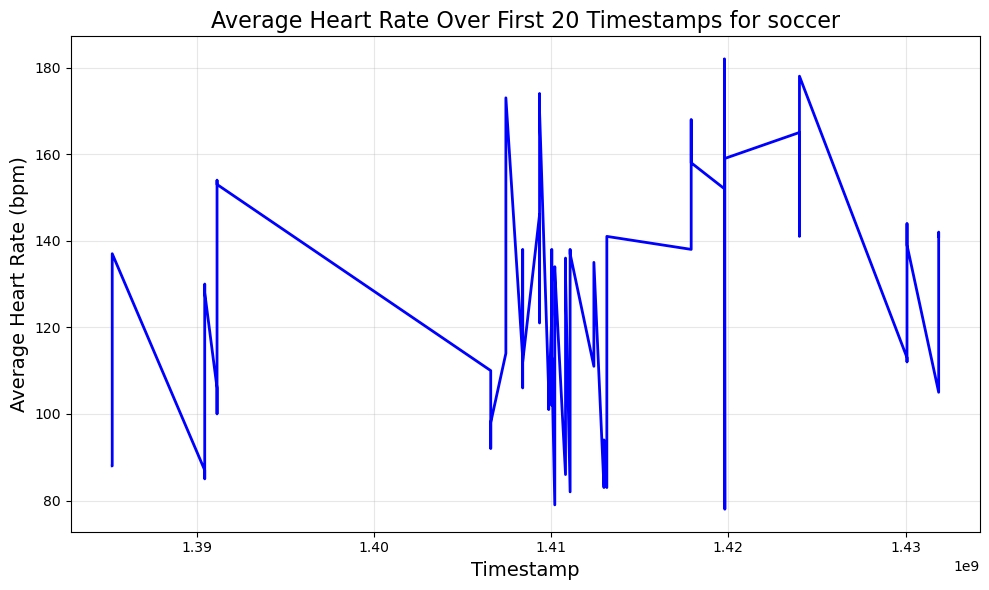

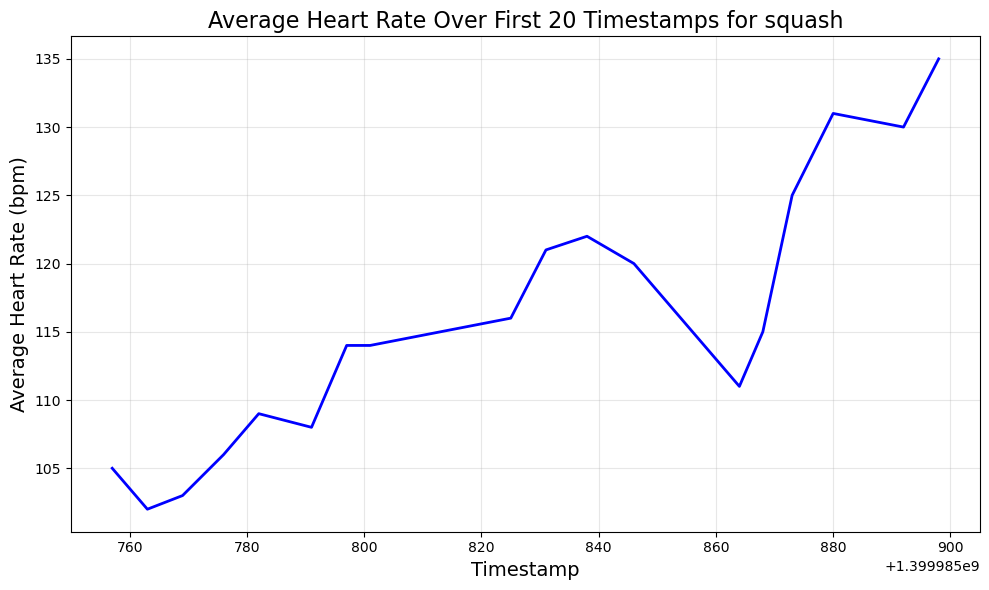

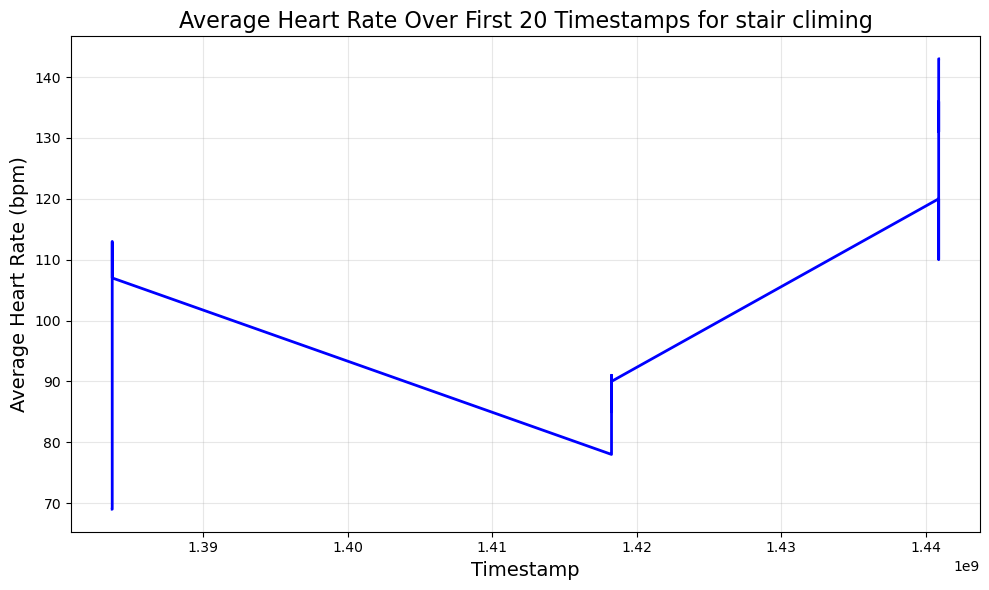

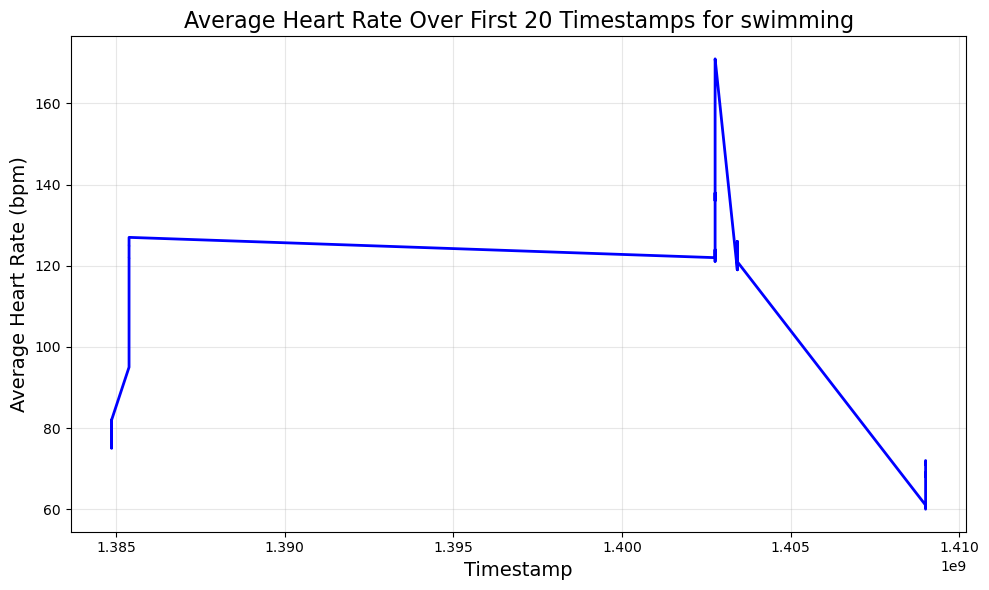

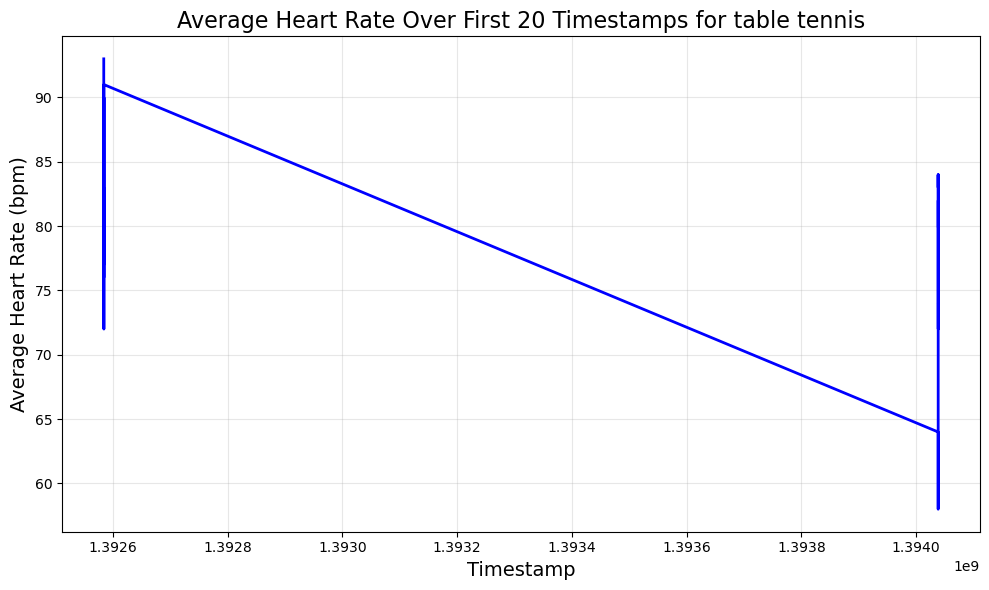

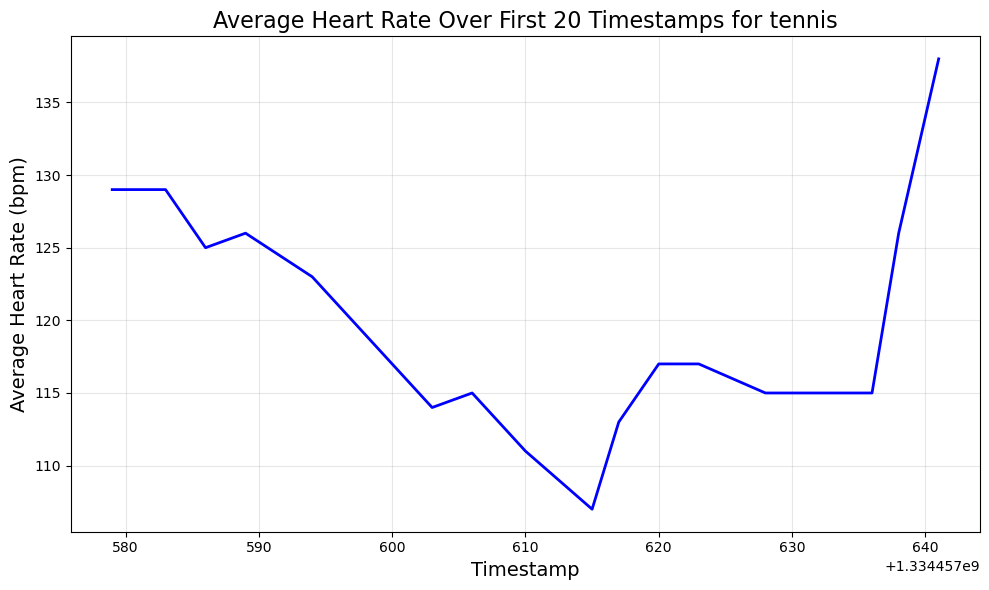

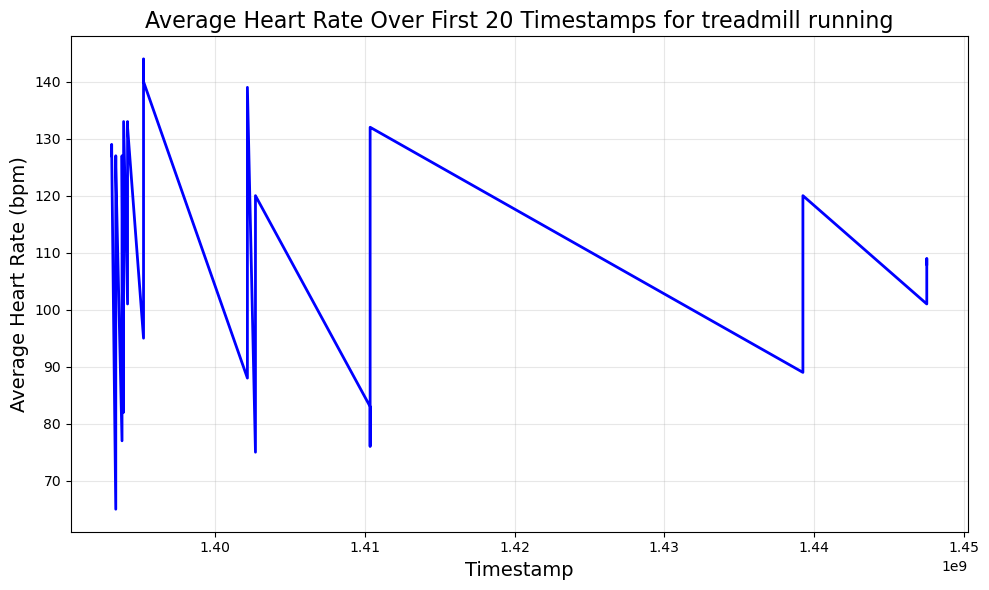

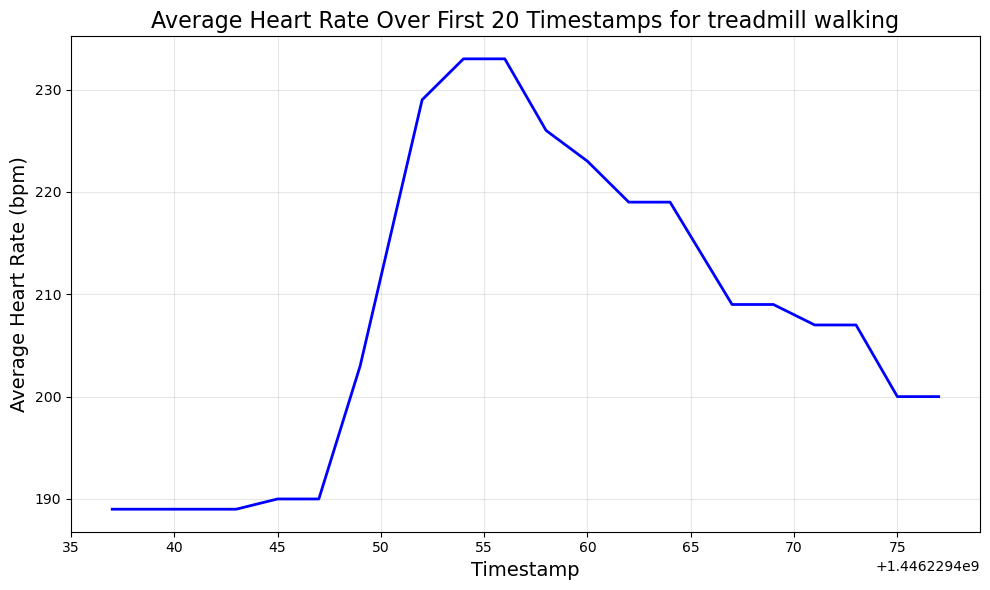

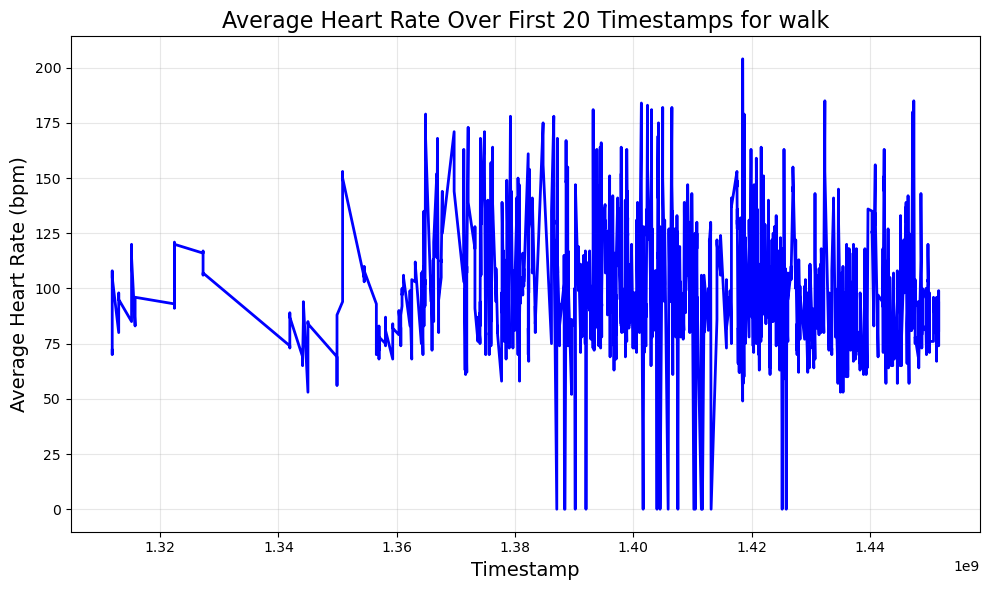

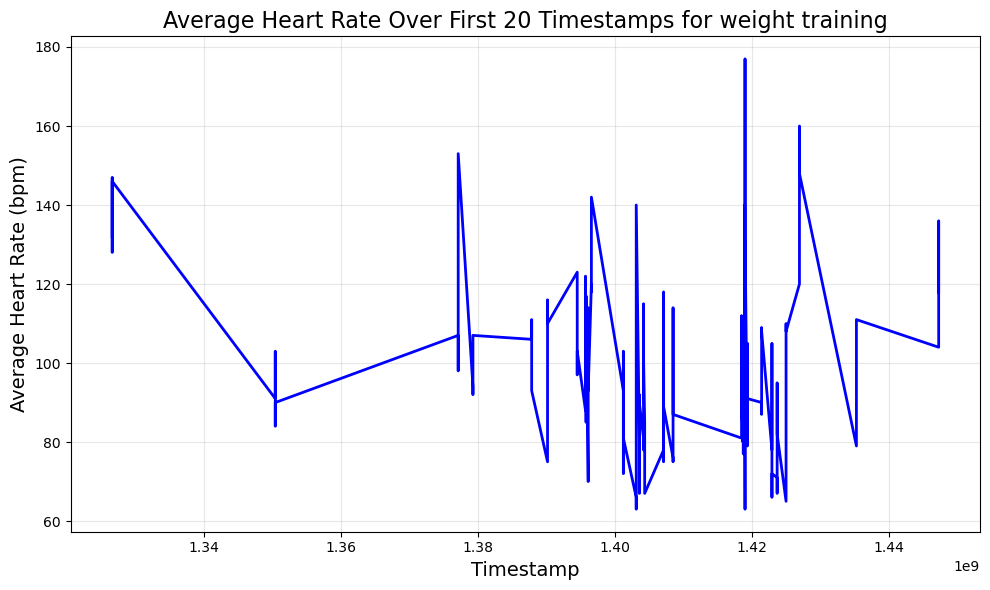

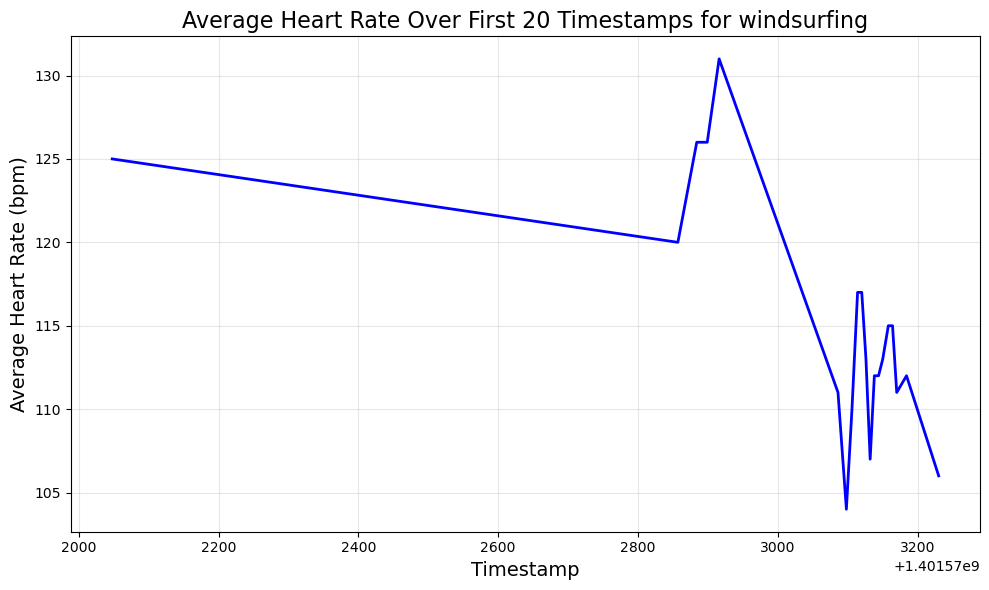

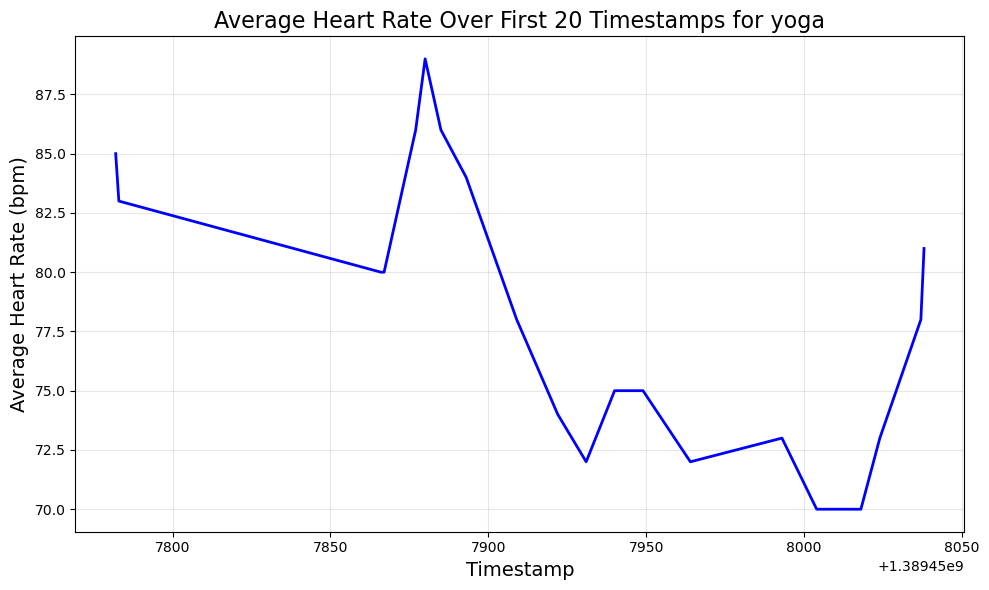

In [5]:
# Step 1: Process only the first 20 timestamps for each user
records2 = []

for entry in data:
    try:
        sport = entry.get('sport', None)
        heart_rate_list = entry.get('heart_rate', [])[:20]  # Take first 20 elements
        timestamp_list = entry.get('timestamp', [])[:20]  # Take first 20 elements
        
        # Append records for each timestamp and heart rate
        for idx in range(len(timestamp_list)):
            records2.append({
                'sport': sport,
                'timestamp': timestamp_list[idx],
                'heart_rate': heart_rate_list[idx]
            })
    except Exception as e:
        print(f"Error processing entry: {e}")

# Step 2: Convert to a DataFrame
df = pd.DataFrame(records2)

# Step 3: Group by sport and timestamp, then calculate average heart rate
sport_time_avg_hr = (
    df.groupby(['sport', 'timestamp'])['heart_rate']
    .mean()
    .reset_index()
)

# Step 4: Plot each sport on a separate graph
unique_sports = sport_time_avg_hr['sport'].unique()

for sport in unique_sports:
    # Filter data for the current sport
    sport_data = sport_time_avg_hr[sport_time_avg_hr['sport'] == sport]
    
    # Create a new figure for each sport
    plt.figure(figsize=(10, 6))
    
    # Plot the sport's data
    plt.plot(
        sport_data['timestamp'], 
        sport_data['heart_rate'], 
        label=f'{sport}', 
        linewidth=2,
        color='blue'
    )
    
    # Customize the plot
    plt.title(f'Average Heart Rate Over First 20 Timestamps for {sport}', fontsize=16)
    plt.xlabel('Timestamp', fontsize=14)
    plt.ylabel('Average Heart Rate (bpm)', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [10]:

from sklearn.cluster import KMeans


# Step 1: Process data into a DataFrame
records = []

for entry in data:
    try:
        sport = entry.get('sport', None)
        heart_rate_list = entry.get('heart_rate', [])
        
        if heart_rate_list:  # Ensure heart rate data exists
            records.append({
                'sport': sport,
                'heart_rate': heart_rate_list
            })
    except Exception as e:
        print(f"Error processing entry: {e}")

df = pd.DataFrame(records)

# Step 2: Calculate Average Heart Rate and HRV (Standard Deviation)
sport_hrv = df.explode('heart_rate')  # Expand heart_rate lists into rows
sport_hrv['heart_rate'] = sport_hrv['heart_rate'].astype(float)

# Group by sport to calculate mean and std (HRV)
sport_features = (
    sport_hrv.groupby('sport')['heart_rate']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'avg_heart_rate', 'std': 'hrv'})
)



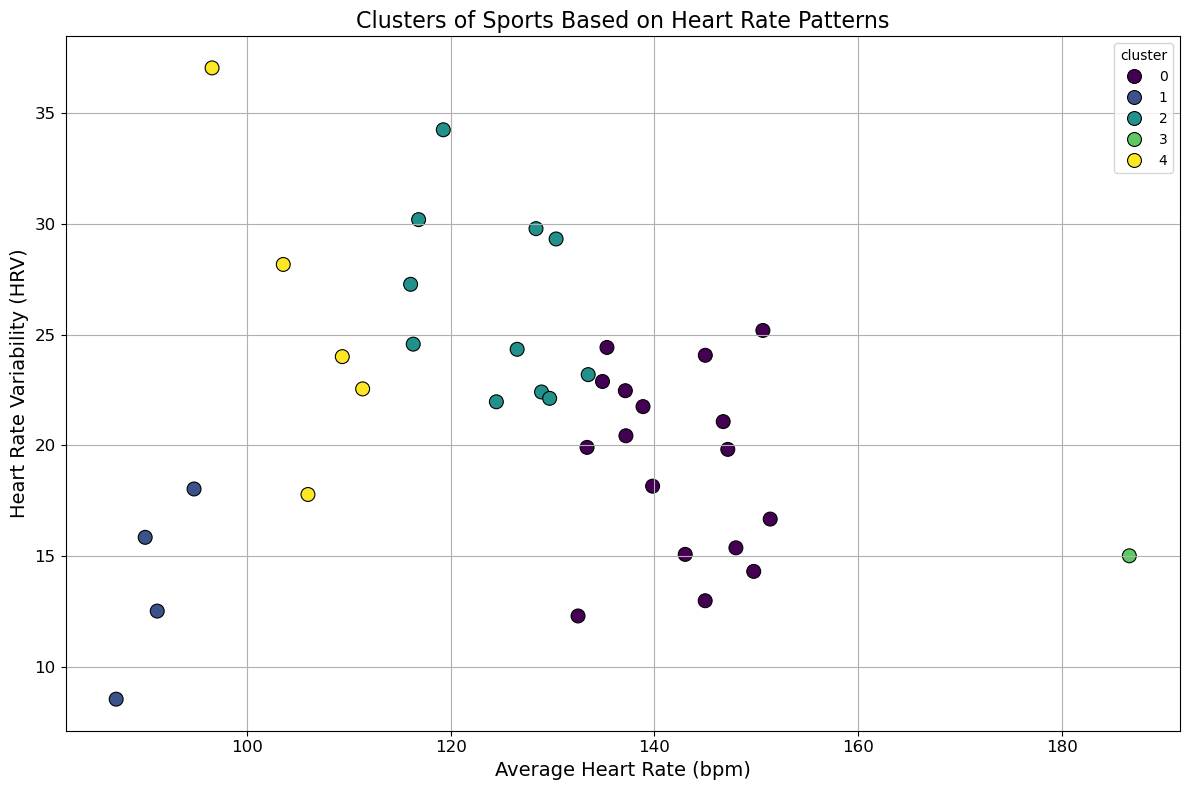

                      sport  avg_heart_rate        hrv  cluster
0                  aerobics      150.649333  25.187563        0
1                 badminton      151.369333  16.664915        0
2                      bike      133.492645  23.191329        2
3          bike (transport)      126.513265  24.335886        2
4          circuit training      116.047590  27.272593        2
5                  climbing      137.196500  20.428547        0
6   core stability training      130.338267  29.321167        2
7      cross-country skiing      138.874769  21.746568        0
8           downhill skiing       96.545333  37.050197        4
9                elliptical      128.907667  22.406662        2
10          fitness walking      116.304690  24.569334        2
11                     golf       89.976400  15.840209        1
12               gymnastics      105.965314  17.775752        4
13                   hiking      111.335363  22.546849        4
14         horseback riding      139.816

In [11]:
# Step 3: Apply K-Means Clustering
# Choosing 3 clusters for simplicity, you can experiment with different numbers
kmeans = KMeans(n_clusters=5, random_state=42)
sport_features['cluster'] = kmeans.fit_predict(sport_features[['avg_heart_rate', 'hrv']])

# Step 4: Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='avg_heart_rate', y='hrv', hue='cluster', palette='viridis', data=sport_features, s=100, edgecolor='black'
)
plt.title('Clusters of Sports Based on Heart Rate Patterns', fontsize=16)
plt.xlabel('Average Heart Rate (bpm)', fontsize=14)
plt.ylabel('Heart Rate Variability (HRV)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# Optionally, display the clusters
print(sport_features[['sport', 'avg_heart_rate', 'hrv', 'cluster']])


Skipped 0 entries due to missing fields.


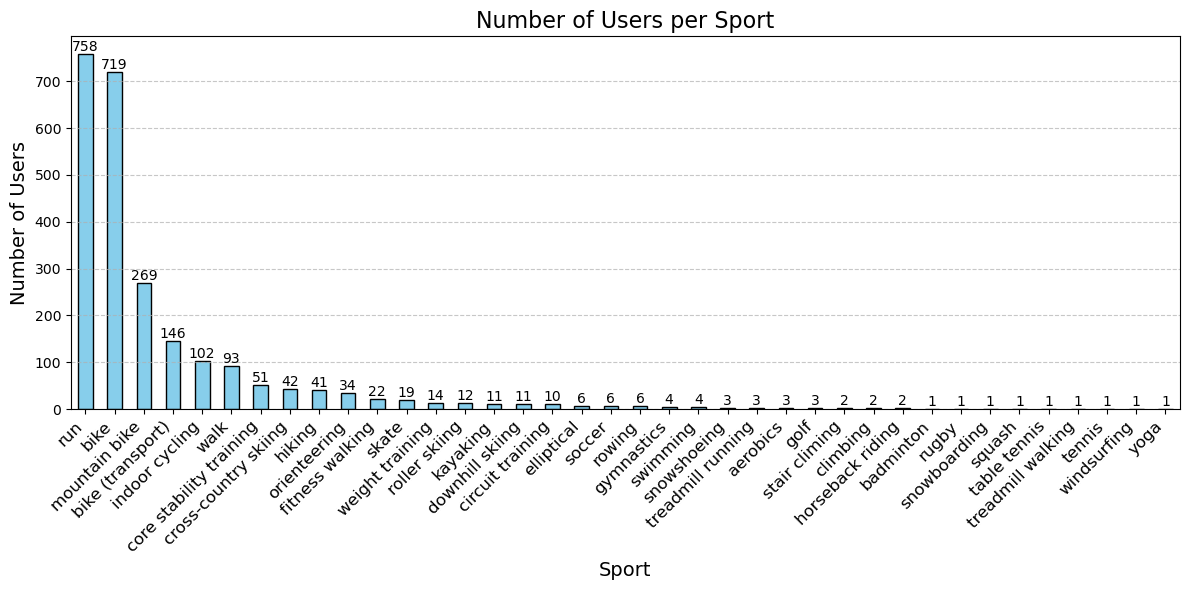

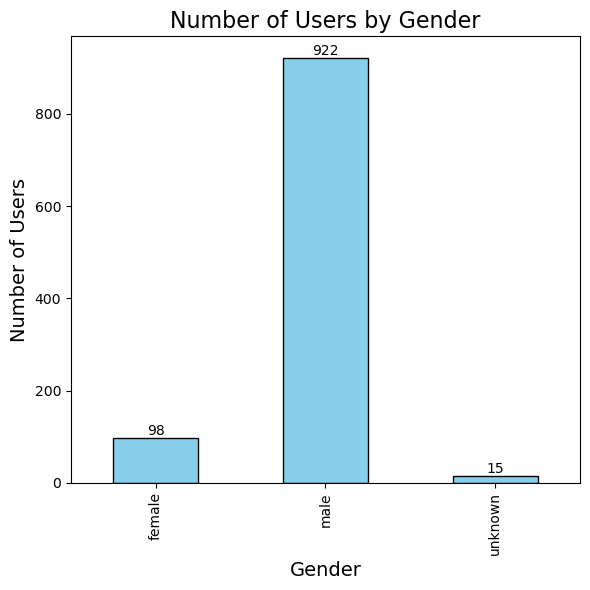

In [12]:
# Step 1: Process data into a DataFrame
records = []
skipped = 0

for entry in data:
    sport = entry.get('sport')
    gender = entry.get('gender')
    user_id = entry.get('userId')
    
    if sport and gender and user_id:
        records.append({'user_id': user_id, 'sport': sport, 'gender': gender})
    else:
        skipped += 1
print(f"Skipped {skipped} entries due to missing fields.")

df = pd.DataFrame(records)

# Step 2: Number of users per sport
sport_counts = df.groupby('sport')['user_id'].nunique()

# Plotting Number of Users per Sport
plt.figure(figsize=(15, 6))
ax = sport_counts.sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(12, 6)
)
plt.title('Number of Users per Sport', fontsize=16)
plt.xlabel('Sport', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations to bars
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Step 3: Number of users by gender
gender_counts = df.groupby('gender')['user_id'].nunique()

# Plotting Number of Users by Gender
plt.figure(figsize=(6, 6))
colors = ['black', 'skyblue'] if len(gender_counts) == 2 else ['skyblue']
ax = gender_counts.plot(kind='bar', color=colors, edgecolor='black', figsize=(6, 6))
plt.title('Number of Users by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)

# Add annotations to bars
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


gender                   female  male  unknown
sport                                         
run                          84   666        8
bike                         50   661        8
mountain bike                15   250        4
bike (transport)             13   132        1
indoor cycling                5    96        1
walk                         19    74        0
core stability training       6    43        2
cross-country skiing          5    37        0
hiking                        5    36        0
orienteering                  5    29        0
fitness walking               2    19        1
skate                         2    17        0
weight training               1    13        0
roller skiing                 2    10        0
kayaking                      1    10        0
downhill skiing               0    11        0
circuit training              2     8        0
elliptical                    0     6        0
soccer                        0     6        0
rowing       

<Figure size 1200x600 with 0 Axes>

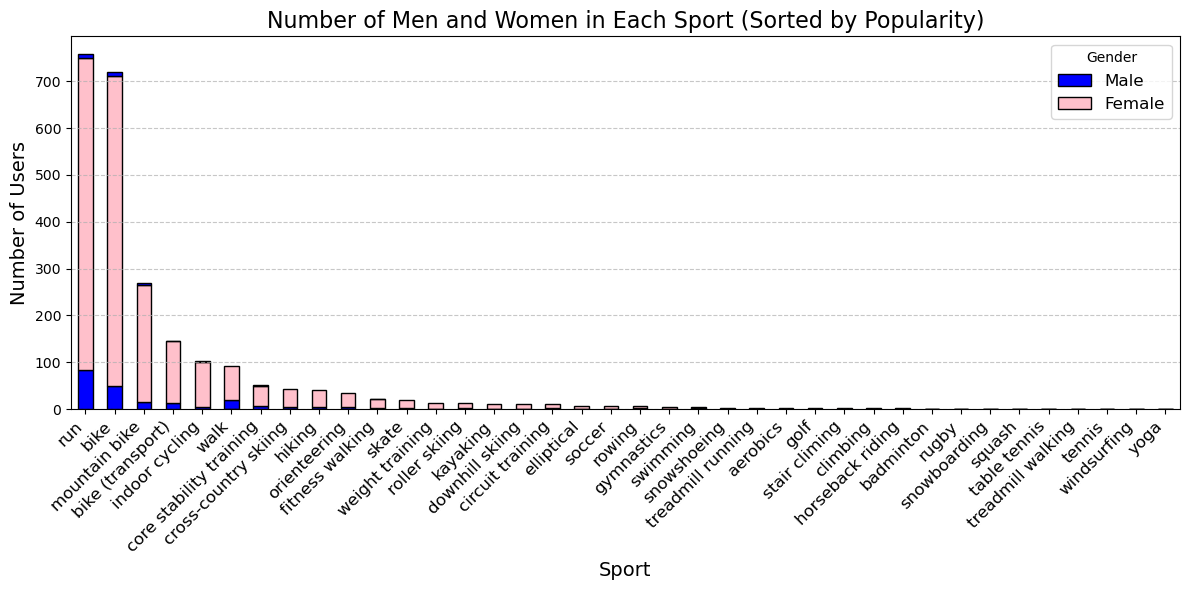

In [17]:
# Group by sport and gender, then count unique user IDs
sport_gender_counts = (
    df.groupby(['sport', 'gender'])['user_id']
    .nunique()  # Count unique users
    .unstack(fill_value=0)  # Pivot gender into separate columns
)

# Add a column for total users to sort by popularity
sport_gender_counts['Total'] = sport_gender_counts.sum(axis=1)

# Sort sports by total number of users (popularity)
sport_gender_counts = sport_gender_counts.sort_values(by='Total', ascending=False)

# Drop the 'Total' column for plotting purposes
sorted_sports = sport_gender_counts.drop(columns='Total')

# Display the sorted table
print(sorted_sports)

# Plot the data as a stacked bar chart
plt.figure(figsize=(12, 6))
sorted_sports.plot(
    kind='bar', 
    stacked=True, 
    color=['blue', 'pink'],  # Use colors to distinguish genders
    edgecolor='black', 
    figsize=(12, 6)
)

# Add titles and labels
plt.title('Number of Men and Women in Each Sport (Sorted by Popularity)', fontsize=16)
plt.xlabel('Sport', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Gender', labels=['Male', 'Female'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()
